In [ ]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import cv2
import time
import mediapipe as mp
from google.protobuf.json_format import MessageToDict
import io
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torchvision.models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
test = torchvision.models.vgg19(weights='VGG19_Weights.DEFAULT')
for param in test.parameters():
    param.requires_grad = False
test.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [4]:
def showarray(a, fmt='jpeg'):
    if isinstance(a, list):
        imgs = [np.uint8(np.clip(img, 0, 255)) for img in a]
        f = io.BytesIO()
        PIL.Image.fromarray(np.concatenate(imgs, axis=1)).save(f, fmt)
        display(Image(data=f.getvalue()))
    else:
        a = np.uint8(np.clip(a, 0, 255))
        f = io.BytesIO()
        PIL.Image.fromarray(a).save(f, fmt)
        display(Image(data=f.getvalue()))

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

class AslDataset(Dataset):
    def __init__(self):
        self.x = []
        self.labels = []
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])
        
        for dtype in data.keys():
            for i in data[dtype]:
                self.labels.append(mp[dtype])
                img_tensor = self.transform(preprocess_image(i))
                self.x.append(img_tensor)
        
        self.labels = torch.tensor(self.labels, dtype=torch.long)
        print("Done")
    def __getitem__(self, index):
        return self.x[index].cpu(), self.labels[index]
    
    def __len__(self):
        return len(self.labels)

In [5]:
datatypes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
data_path = '/home/aravos/ASL-data/asl_alphabet_train/asl_alphabet_train'
data = {i: [] for i in datatypes}
mp = {datatypes[i]: i for i in range(len(datatypes))}
for dtype in data.keys():
    temp_path = os.path.join(data_path, dtype)
    for filename in os.listdir(temp_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')) and 'Zone.Identifier' not in filename:
            data[dtype].append(os.path.join(temp_path, filename))

In [6]:
dataset = AslDataset()

Done


In [79]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

29


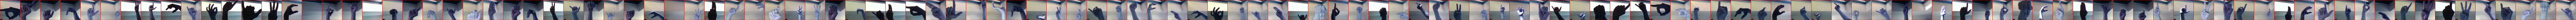

In [80]:
# Hyper Parameters
learning_rate = 0.01
num_epochs = 19
batch_size = 128
train_test_split = 0.8
num_classes = 29

classes = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space')
print(len(classes))
def imshow(img):
    plt.imshow(img)
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)
l = []
for i in range (len(images)):
    img = images[i].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.uint8(img * 255)
    l.append(img)

showarray(l)

In [45]:
class FineTunedModel(nn.Module):
    def __init__(self):
        super(FineTunedModel, self).__init__()
        self.premodel = torchvision.models.vgg19(weights='VGG19_Weights.DEFAULT')
        for param in self.premodel.parameters():
            param.requires_grad = False
        self.premodel.classifier[6] = nn.Linear(4096,29)
        self.premodel.classifier[6].weight.requires_grad = True
        self.premodel.classifier[6].bias.requires_grad = True

    def forward(self, x):
        x = self.premodel(x)
        return x


model = FineTunedModel().to(device)

In [81]:
# Creating a seperate fc layer instead of using and retraining the one on the Model
# 10% increased accuracy 
class FineTunedModel(nn.Module):
    def __init__(self):
        super(FineTunedModel, self).__init__()
        self.premodel = torchvision.models.vgg19(weights='VGG19_Weights.DEFAULT')
        for param in self.premodel.parameters():
            param.requires_grad = False
        # premodel.fc.in_features Won't work for VGG19
        # Using self.premodel.classifier[6].in_features we can find the final layer in features and mod final layer (4096 here)
        self.fc = nn.Linear(self.premodel.classifier[6].out_features,29)

    def forward(self, x):
        x = self.premodel(x)
        x = F.relu(x)
        x = self.fc(x)
        return x

model = FineTunedModel().to(device)

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model.train()
n_total_steps = len(train_loader)
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if (i+1) % 50 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    step_lr_scheduler.step()

print('Finished Training')

Epoch [1/19], Step [50/544], Loss: 2.4629
Epoch [1/19], Step [100/544], Loss: 1.2648
Epoch [1/19], Step [150/544], Loss: 1.2917
Epoch [1/19], Step [200/544], Loss: 1.0736
Epoch [1/19], Step [250/544], Loss: 1.4978
Epoch [1/19], Step [300/544], Loss: 0.9876
Epoch [1/19], Step [350/544], Loss: 1.1637
Epoch [1/19], Step [400/544], Loss: 1.7706
Epoch [1/19], Step [450/544], Loss: 1.4929
Epoch [1/19], Step [500/544], Loss: 1.8301
Epoch [2/19], Step [50/544], Loss: 1.0505
Epoch [2/19], Step [100/544], Loss: 1.4058
Epoch [2/19], Step [150/544], Loss: 0.8822
Epoch [2/19], Step [200/544], Loss: 1.1529
Epoch [2/19], Step [250/544], Loss: 1.8877
Epoch [2/19], Step [300/544], Loss: 2.1462
Epoch [2/19], Step [350/544], Loss: 1.8984
Epoch [2/19], Step [400/544], Loss: 1.2537
Epoch [2/19], Step [450/544], Loss: 1.2019
Epoch [2/19], Step [500/544], Loss: 1.0212
Epoch [3/19], Step [50/544], Loss: 1.6319
Epoch [3/19], Step [100/544], Loss: 1.3683
Epoch [3/19], Step [150/544], Loss: 2.1858
Epoch [3/19], 

In [56]:
PATH = './Pcnn3.pth'
torch.save(model.state_dict(), PATH)
print('Saved')

Saved


In [84]:
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for _ in range(29)]
    n_class_samples = [0 for _ in range(29)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(29):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 94.97126436781609 %
Accuracy of A: 96.21451104100946 %
Accuracy of B: 97.1947194719472 %
Accuracy of C: 99.83079526226734 %
Accuracy of D: 97.26775956284153 %
Accuracy of E: 92.4914675767918 %
Accuracy of F: 97.10884353741497 %
Accuracy of G: 93.7062937062937 %
Accuracy of H: 99.49748743718592 %
Accuracy of I: 92.76315789473684 %
Accuracy of J: 94.99105545617174 %
Accuracy of K: 94.94949494949495 %
Accuracy of L: 97.86535303776684 %
Accuracy of M: 95.00780031201248 %
Accuracy of N: 94.96855345911949 %
Accuracy of O: 94.07294832826747 %
Accuracy of P: 98.7012987012987 %
Accuracy of Q: 97.41379310344827 %
Accuracy of R: 87.45980707395498 %
Accuracy of S: 90.06410256410257 %
Accuracy of T: 93.52750809061489 %
Accuracy of U: 93.59190556492412 %
Accuracy of V: 85.59602649006622 %
Accuracy of W: 94.17989417989418 %
Accuracy of X: 86.46362098138748 %
Accuracy of Y: 95.6738768718802 %
Accuracy of Z: 97.38219895287958 %
Accuracy of del: 98.91696750902527 %
Accuracy of n

In [90]:
def run(name,label):
    path = './vid/'+name+'.jpeg'
    imag = preprocess_image(path)
    showarray(imag)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])
    
    imag = transform(imag)
    imag = imag.unsqueeze(0)
    imag = imag.to(device)
    outputs = model(imag)
    _, predicted = torch.max(outputs, 1)
    print(f'Actual label: {label}, Predicted label: {datatypes[predicted.item()]}')
    # Testing Saved Model
    imag = cv2.flip(preprocess_image(path),1)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])
    
    imag = transform(imag)
    imag = imag.unsqueeze(0)
    imag = imag.to(device)
    outputs = model(imag)
    _, predicted = torch.max(outputs, 1)
    print(f'Actual label: {label}, Predicted label: {datatypes[predicted.item()]}')

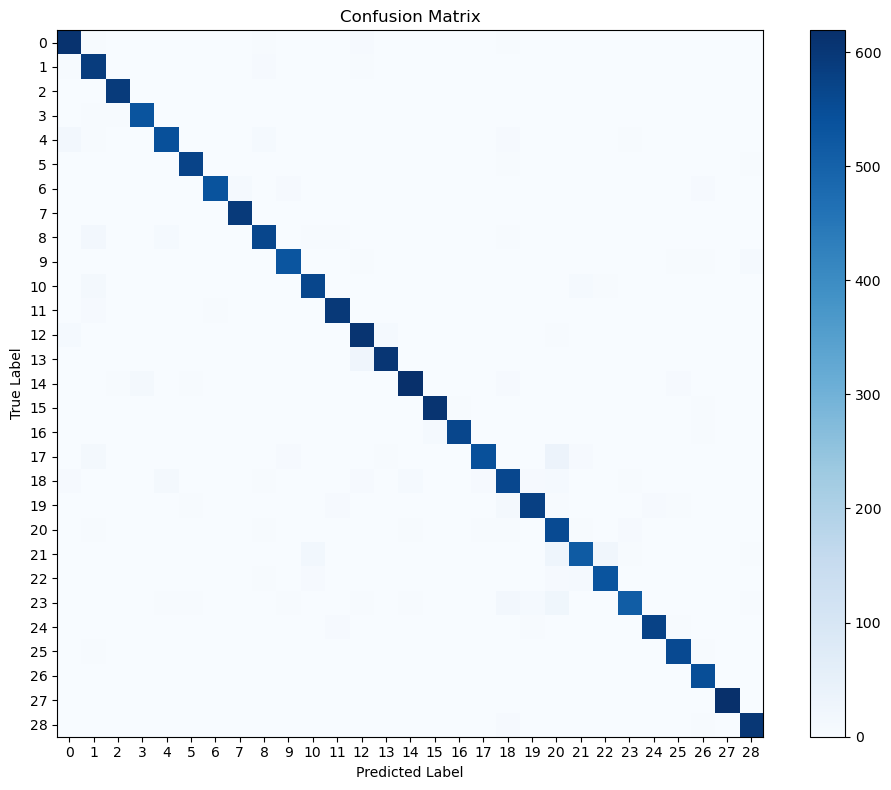

In [89]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def compute_confusion_matrix(true_labels, predicted_labels, num_classes):
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for t, p in zip(true_labels.view(-1), predicted_labels.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix

model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

true_labels_tensor = torch.tensor(true_labels)
predicted_labels_tensor = torch.tensor(predicted_labels)
conf_matrix = compute_confusion_matrix(true_labels_tensor, predicted_labels_tensor, num_classes=29)
conf_matrix_np = conf_matrix.numpy()
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_np, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(29)
plt.xticks(tick_marks, np.arange(29))
plt.yticks(tick_marks, np.arange(29))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

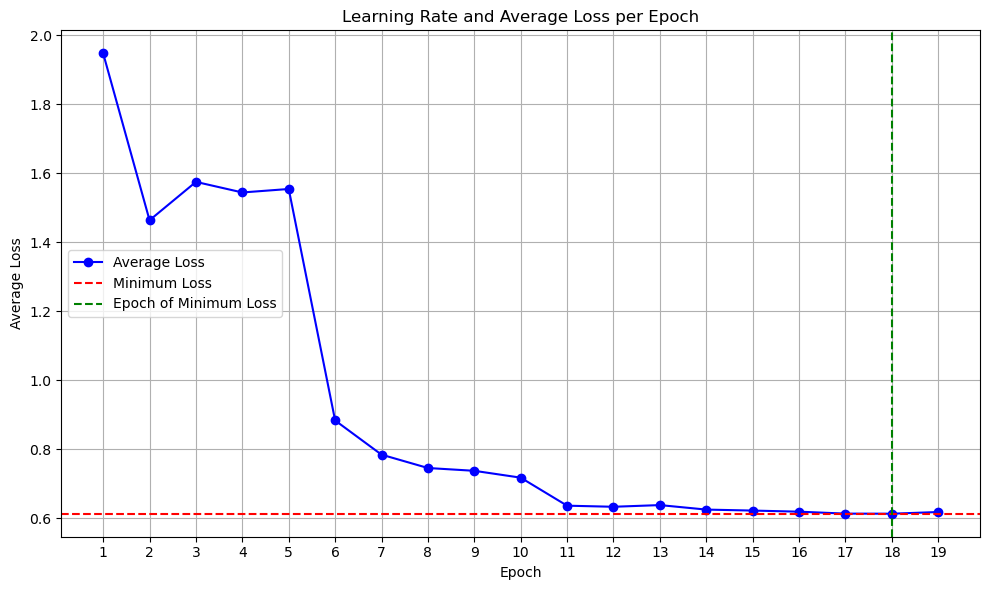

[1.9468930049196762, 1.4632108769215204, 1.5743886112947674, 1.5437258088632542, 1.5538071799365913, 0.8829761590151226, 0.7838772962636807, 0.7451927314019379, 0.7370724604081582, 0.7172188480001163, 0.6360199733034653, 0.6328488269492107, 0.6377337975975346, 0.6246971064247191, 0.6218461372396525, 0.6186580001102651, 0.6129945864462677, 0.6127627736560124, 0.6176555367624935]


In [87]:
import matplotlib.pyplot as plt
lr = 0.01
gamma = 0.1
stepsize = 5
epochs = list(range(1, 20))
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Average Loss')
plt.title('Learning Rate and Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.xticks(epochs)
plt.axhline(y=min(losses), color='r', linestyle='--', label='Minimum Loss')
plt.axvline(x=epochs[losses.index(min(losses))], color='g', linestyle='--', label='Epoch of Minimum Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(losses)